I am investigating two chromatin-bound proteins X and Y. Here is what I know about these proteins:

* X protein is two-fold more abundant than protein Y. 
* Protein Y always co-localizes with protein X. 
* Protein X co-localizes with protein Y at some genomic locations (X with Y sites), while at other locaionts it does not (X without Y sites). 
* The function of protein X depends on the presence of protein Y.  

I wanted to know which genomic features characterize the sites where protein X co-localizes with Y. To do so, I first stratified ChIP-seq peaks of protein X into two groups depending on the ChIP-seq signal of protein Y: X with Y and X without Y. I then characterized each peak using 80 features and implemented a Random Forests (RF) machine learning algorithm. 

In [1]:
# import standard python libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from pprint import pprint

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

## Set plotting parameters

In [3]:
mpl.rcParams.update({'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'axes.labelsize': 16,
                     'font.size': 16})

## Define functions

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Upload data 

The features I upload here have been previously checked for the feature correlation. 

In [5]:
df = pd.read_csv('/groups/gerlich/experiments/Experiments_005700/005752/jupyter_notebooks/For_CV/proteinX_features.bed', sep = '\t')
df.tail()

,chrom,start,end,mid,proteinY,compType,ctcf_forw_plus_rev_1000,ctcf_forw_plus_rev_10000,CTCF_orientaition'-1',CTCF_orientaition'-1-1',...,H3K4me3_chip_signal,H3K79me2_chip_signal,H3K9ac_chip_signal,H4K20me1_chip_signal,Ezh2_chip_signal,H2Az_chip_signal,H3K36me3_chip_signal,H3K9me3_chip_signal,Pol2_chip_signal,Brf1_chip_signal
23291,chr12,12964786,12967309,12966047,0.0,0,1.0,1.0,0,0,...,0.607768,0.410474,0.527049,-0.002049,0.012246,0.098642,-0.004358,-0.006143,0.031233,0.071243
23292,chr1,43701145,43701929,43701537,0.0,0,1.0,3.0,0,0,...,0.023026,0.031345,0.076854,0.006476,0.004443,0.078083,-0.007881,0.017175,0.030685,0.005828
23293,chr1,31654301,31654773,31654537,0.0,0,1.0,2.0,0,0,...,0.205405,-0.010869,0.008527,-0.016903,0.035547,0.116652,-0.017768,0.014693,0.022755,0.000000
23294,chr13,24793667,24794973,24794320,0.0,0,1.0,2.0,0,1,...,0.010655,0.026486,0.001916,0.032576,0.020982,0.013738,0.010595,0.000545,0.011745,0.030033
23295,chr8,116962084,116962835,116962459,0.0,0,1.0,1.0,1,0,...,0.014112,-0.033101,-0.007429,0.036616,0.003289,0.023110,0.019564,0.019443,0.005782,0.036219


## Pre-process the data

In [6]:
 # define X - features characterizing each peak of protein X
X = df.drop(['chrom', 'start', 'end', 'mid', 'proteinY'], axis = 1)
feature_names = X.columns
X = np.asarray(X)
# define y - ground truth. Column 'proteinY' is a binary column defining 
# wheather protein X co-localizes with protein Y at a certain site 
y = df['proteinY']

## Standardize features

In [7]:
#standardize features by removing the mean and scaling to unit variance
X = preprocessing.StandardScaler().fit(X).transform(X)

## Split the data into test and train datasets

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [9]:
print('Shape of X training set {}'.format(x_train.shape),'&',' Size of Y training set {}'.format(y_train.shape))

Shape of X training set (18636, 80) &  Size of Y training set (18636,)


## Set-up RF classifier using default parameters 

In [10]:
rf = RandomForestClassifier(class_weight = 'balanced')
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [11]:
y_pred = rf.predict(x_test)

## Evaluate the performance of the classifier

              precision    recall  f1-score   support

         0.0       0.72      0.74      0.73      2278
         1.0       0.74      0.73      0.74      2382

    accuracy                           0.73      4660
   macro avg       0.73      0.73      0.73      4660
weighted avg       0.73      0.73      0.73      4660

Confusion matrix, without normalization


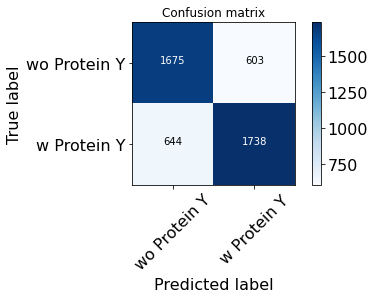

In [12]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=['wo Protein Y','w Protein Y'],
                      normalize = False,
                      title='Confusion matrix')

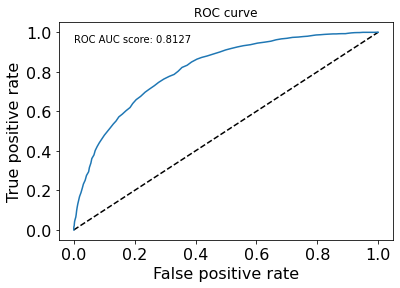

In [13]:
# ROC AUC curve
y_pred_proba = rf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.text (0, 0.95, f"ROC AUC score: {np.round(auc(fpr, tpr),4)}");

# tune the hyperparameters 

In [14]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [15]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 60, 110, None],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 10],
 'n_estimators': [200, 600, 1000]}


In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight = 'balanced')
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

/users/sofia.kolesnikova/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 60, 110, None],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 10],
                                        'n_estimators': [200, 600, 1000]},
                   random_state=42)

In [18]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': True}

In [19]:
best_random = rf_random.best_estimator_
y_pred = best_random.predict(x_test)

## Evaluate the performance of the RF classifier with updated hyperparameters

              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73      2278
         1.0       0.74      0.74      0.74      2382

    accuracy                           0.74      4660
   macro avg       0.74      0.74      0.74      4660
weighted avg       0.74      0.74      0.74      4660

Confusion matrix, without normalization


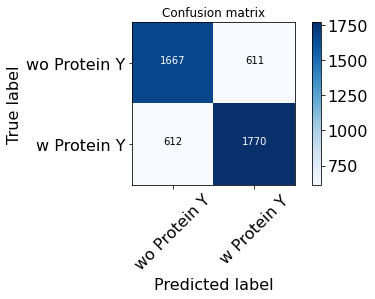

In [20]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=['wo Protein Y','w Protein Y'],
                      normalize = False,
                      title='Confusion matrix')

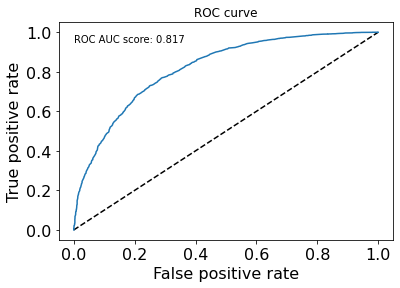

In [21]:
# ROC AUC curve
y_pred_proba = best_random.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.text (0, 0.95, f"ROC AUC score: {np.round(auc(fpr, tpr),4)}");

## Calculate the feature importance 

In [22]:
importances = best_random.feature_importances_
unsorted_list = [(importance, feature) for feature, importance in 
                  zip(feature_names, importances)]
sorted_list = sorted(unsorted_list)

features_sorted = []
importance_sorted = []
for i in sorted_list:
    features_sorted += [i[1]]
    importance_sorted += [i[0]]

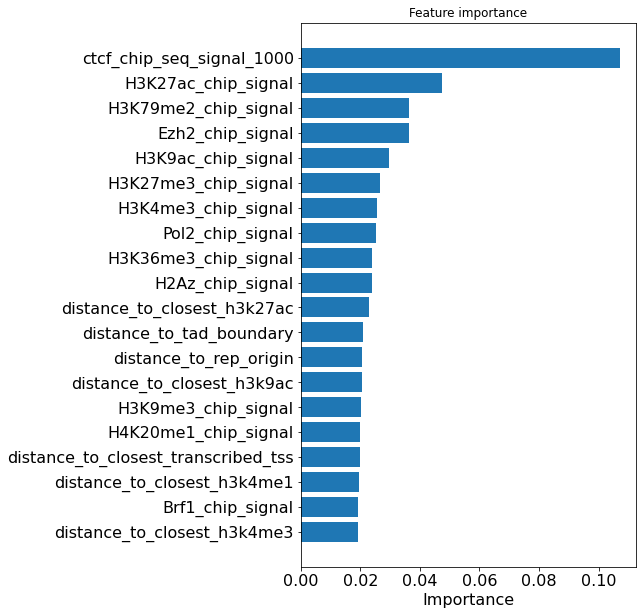

In [23]:
f = plt.figure(figsize=(6,10))
plt.title("Feature importance")
plt.xlabel("Importance")
plt.barh(range(len(importance_sorted[60:])), importance_sorted[60:])
plt.yticks(range(len(importance_sorted[60:])), features_sorted[60:])
plt.show()

The CTCF signal is the key predictor of protein X co-localizing with protein Y. 